In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from decision_tree import DecisionTree, accuracy_metric, balanced_accuracy_metric

from collections import Counter

import numpy as np
%matplotlib inline

In [2]:
class RandomForest:
    def __init__(self, n_trees=5, oobs=False):
        self.n_trees = n_trees
        self.min_leaf = 1
        self._oobs = oobs
        self.forest = []
        self._out_of_bag = []
        self.out_of_bag_list = []

    def _get_bootstrap(self, data, labels, n_trees: int) -> list:
        n_samples = data.shape[0]
        bootstrap = []

        for i in range(n_trees):
            b_data = np.zeros(data.shape)
            b_labels = np.zeros(labels.shape)
            oob_list = []
            for j in range(n_samples):
                sample_index = np.random.randint(0, n_samples)
                b_data[j] = data[sample_index]
                b_labels[j] = labels[sample_index]
                # запишем рандомные значения выборки для того, чтобы потом найти, что не вошло
                oob_list.append(sample_index)
            bootstrap.append((b_data, b_labels))
            # запишем невошедшие индексы
            self._out_of_bag.append(list(set([_k for _k in range(n_samples)]) - set(oob_list)))

        return bootstrap

    def fit(self, data, labels):
        data = np.array(data)
        labels = np.array(labels)
        bootstrap = self._get_bootstrap(data, labels, self.n_trees)
        _i = 0

        for b_data, b_labels in bootstrap:
            mod = DecisionTree(min_leaf=1, ensemble=True)
            mod.fit(b_data, b_labels)
            # посчитаем balanced accuracy на oob выборке
            oob_acc = self.balanced_accuracy_metric(labels[self._out_of_bag[_i]],
                                                    mod.predict(data[self._out_of_bag[_i]]))
            self.forest.append(mod)
            self.out_of_bag_list.append(oob_acc)
            _i += 1

    def out_of_bag_score(self):
        # вернем среднее значение balanced accuracy на out-of-bag выборках
        return np.mean(self.out_of_bag_list)

    def predict(self, data):
        data = np.array(data)
        # добавим предсказания всех деревьев в список
        predictions = []
        for tree in self.forest:
            predictions.append(tree.predict(data))

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        if not self._oobs:
            for obj in predictions_per_object:
                voted_predictions.append(max(set(obj), key=obj.count))
        else:
            # В качестве выбора метки класса пока выбрал сумму OOBS по каждому классу. Если 
            # у отрицательного класса сумма метрик каждого проголосовавшего больше чем у 
            # положительного, то в результат пишем 0, иначе 1
            acc = np.array(self.out_of_bag_list)
            for obj in predictions_per_object:
                obj = np.array(obj)
                zero_index = (obj <= 0).nonzero()
                non_zero_index = (obj > 0).nonzero()
                if sum(acc[zero_index]) >= sum(acc[non_zero_index]):
                    voted_predictions.append(0)
                else:
                    voted_predictions.append(1)

        return voted_predictions

    @staticmethod
    def balanced_accuracy_metric(actual, predicted):
        true_predicted = (actual == predicted).astype(np.int8)
        sensitivity = np.sum(actual * true_predicted) / np.sum(actual == 1)
        specificity = np.sum((1 - actual) * true_predicted) / np.sum(actual == 0)
        return 0.5 * (sensitivity + specificity)

1) Реализовать оценку Out-of-Bag ошибок для каждого из деревьев леса

In [3]:
RND_STATE = 42
np.random.seed(RND_STATE)
dataset = load_breast_cancer()
X = dataset['data']
y = dataset['target']
train_data, test_data, train_labels, test_labels = train_test_split(X,
                                                                    y,
                                                                    test_size=0.3,
                                                                    random_state=RND_STATE)

In [4]:
train_acc = []
test_acc = []
for i in range(1, 26):
    mod = RandomForest(i)
    mod.fit(train_data, train_labels)
    train = mod.predict(train_data)
    test = mod.predict(test_data)
    train_acc.append(balanced_accuracy_metric(train_labels, train))
    test_acc.append(balanced_accuracy_metric(test_labels, test))

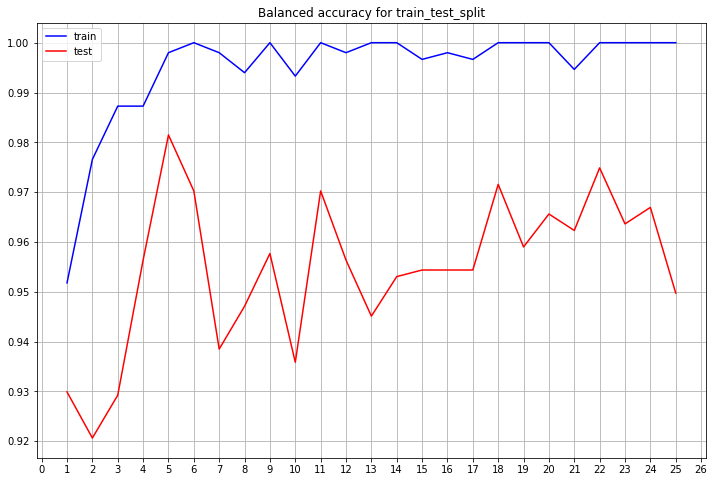

In [5]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, 26), train_acc, color='blue', label='train')
plt.plot(np.arange(1, 26), test_acc, color='red', label='test')
plt.legend(loc='best')
plt.grid()
plt.title('Balanced accuracy for train_test_split')
plt.xticks(np.arange(27))
plt.show()

In [6]:
mod = RandomForest(15)
mod.fit(X, y)
x_pred = mod.predict(X)

In [7]:
for i, tree in enumerate(mod.out_of_bag_list, start=1):
    print(f'Дерево {i}: {tree}')

Дерево 1: 0.9603680853288716
Дерево 2: 0.9112383679312813
Дерево 3: 0.9116511668713809
Дерево 4: 0.9111991496762972
Дерево 5: 0.9404683917458238
Дерево 6: 0.9500207210940738
Дерево 7: 0.9067364347902559
Дерево 8: 0.8883845677738808
Дерево 9: 0.904291224686596
Дерево 10: 0.9393137254901961
Дерево 11: 0.9644662648259771
Дерево 12: 0.9010882066707954
Дерево 13: 0.936038961038961
Дерево 14: 0.9213037364403375
Дерево 15: 0.9251162790697675


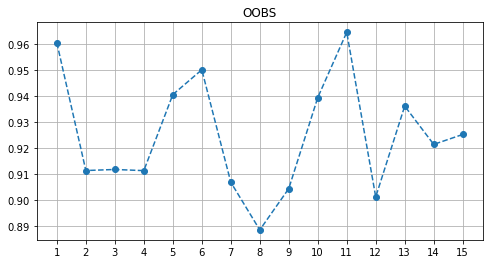

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, 16), mod.out_of_bag_list, linestyle='--', marker='o')
plt.title('OOBS')
plt.xticks(np.arange(1, 16))
plt.grid();

In [9]:
print(f'OOBS на полной выборке: {mod.out_of_bag_score()}')

OOBS на полной выборке: 0.9247790188956331


2) Реализовать голосование деревьев на основе полученного OOBS

In [12]:
n_trees = 15

In [13]:
mod_wo_oobs = RandomForest(n_trees, oobs=False)
mod_wo_oobs.fit(train_data, train_labels)
train = mod_wo_oobs.predict(train_data)
test = mod_wo_oobs.predict(test_data)
print(f'Train: {balanced_accuracy_metric(train_labels, train)}, '
      f'Test: {balanced_accuracy_metric(test_labels, test)}')

Train: 1.0, Test: 0.9543650793650793


In [14]:
mod_w_oobs = RandomForest(n_trees, oobs=True)
mod_w_oobs.fit(train_data, train_labels)
train = mod_w_oobs.predict(train_data)
test = mod_w_oobs.predict(test_data)
print(f'Train: {balanced_accuracy_metric(train_labels, train)}, '
      f'Test: {balanced_accuracy_metric(test_labels, test)}')

Train: 1.0, Test: 0.966931216931217
